<!--NAVIGATION-->

<a href="https://colab.research.google.com/github/bpesquet/machine-learning-handbook/blob/master/deep-learning/MLP.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# Shallow Neural Networks

## Package setup

In [51]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import to_categorical

# Display plots inline, change default figure size and change plot resolution to retina
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 8]
%config InlineBackend.figure_format = 'retina'
# Set Seaborn aesthetic parameters to defaults
sns.set()

## Utility functions

In [52]:
def plot_data(X, y):
    """Plot some data"""

    plt.figure()
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'ob', alpha=0.5, label=1)
    plt.legend()


def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)


def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['acc']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_acc' in history.history:
        val_acc = history.history['val_acc']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()
    

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N * K, D))
    y = np.zeros(N * K)
    for j in range(K):
        ix = range(N * j, N * (j + 1))
        # radius
        r = np.linspace(0.0, 1, N)
        # theta
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Set1, alpha=0.8)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    return X, y


def plot_multiclass_decision_boundary(model, X, y):
    """Plot a multiclass decision boundary"""

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))
    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.tab20b_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Set1)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Planar data

Inspired by [this article](https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6).

In [1]:
# Generate some linearly separable data
x_train, y_train = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                                       n_informative=2, random_state=7, n_clusters_per_class=1)
print('Input shape: ' + str(x_train.shape) +
      '. Targets shape: ' + str(y_train.shape))
plot_data(x_train, y_train)

NameError: name 'make_classification' is not defined

Accuracy: 99.9%


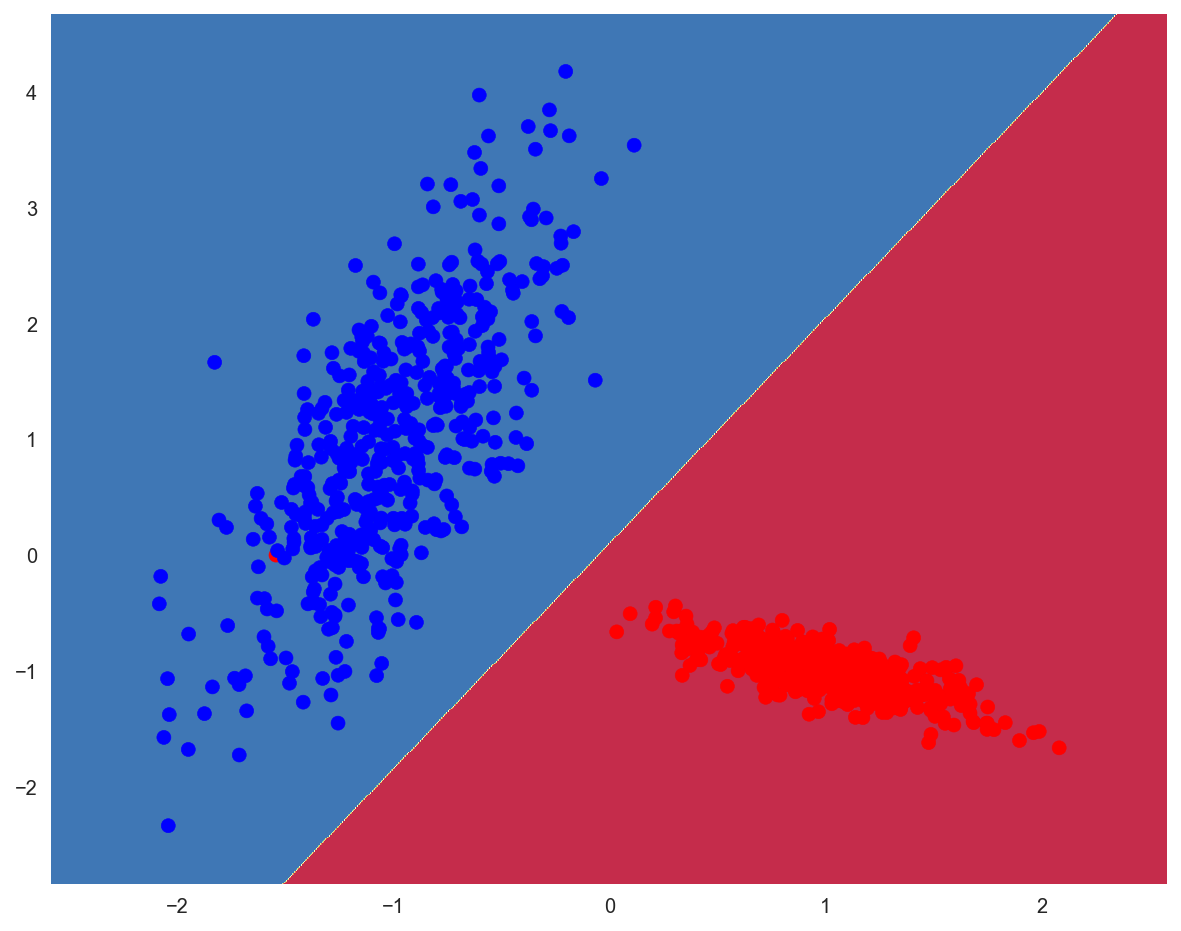

In [54]:
# Use scikit-learn's built-in logistic regression classifier on the data
model = LogisticRegression()
model.fit(x_train, y_train)

accuracy = model.score(x_train, y_train)
print('Accuracy: ' + str(accuracy * 100) + '%')

plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

Input shape: (1000, 2). Targets shape: (1000,)


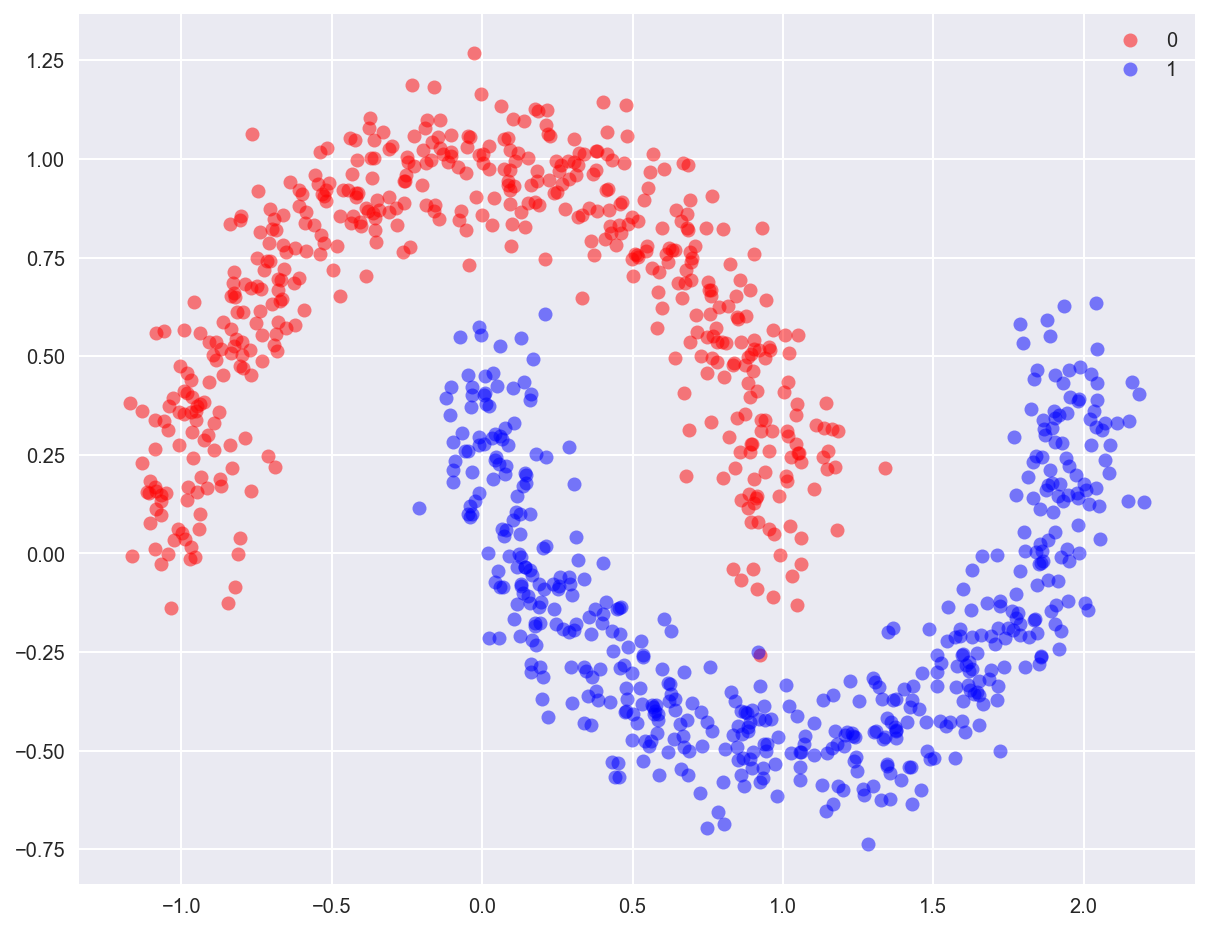

In [55]:
# Generate moon-shaped, non-linearly separable data
x_train, y_train = make_moons(n_samples=1000, noise=0.10, random_state=0)
print('Input shape: ' + str(x_train.shape) +
      '. Targets shape: ' + str(y_train.shape))
plot_data(x_train, y_train)

Accuracy: 87.4%


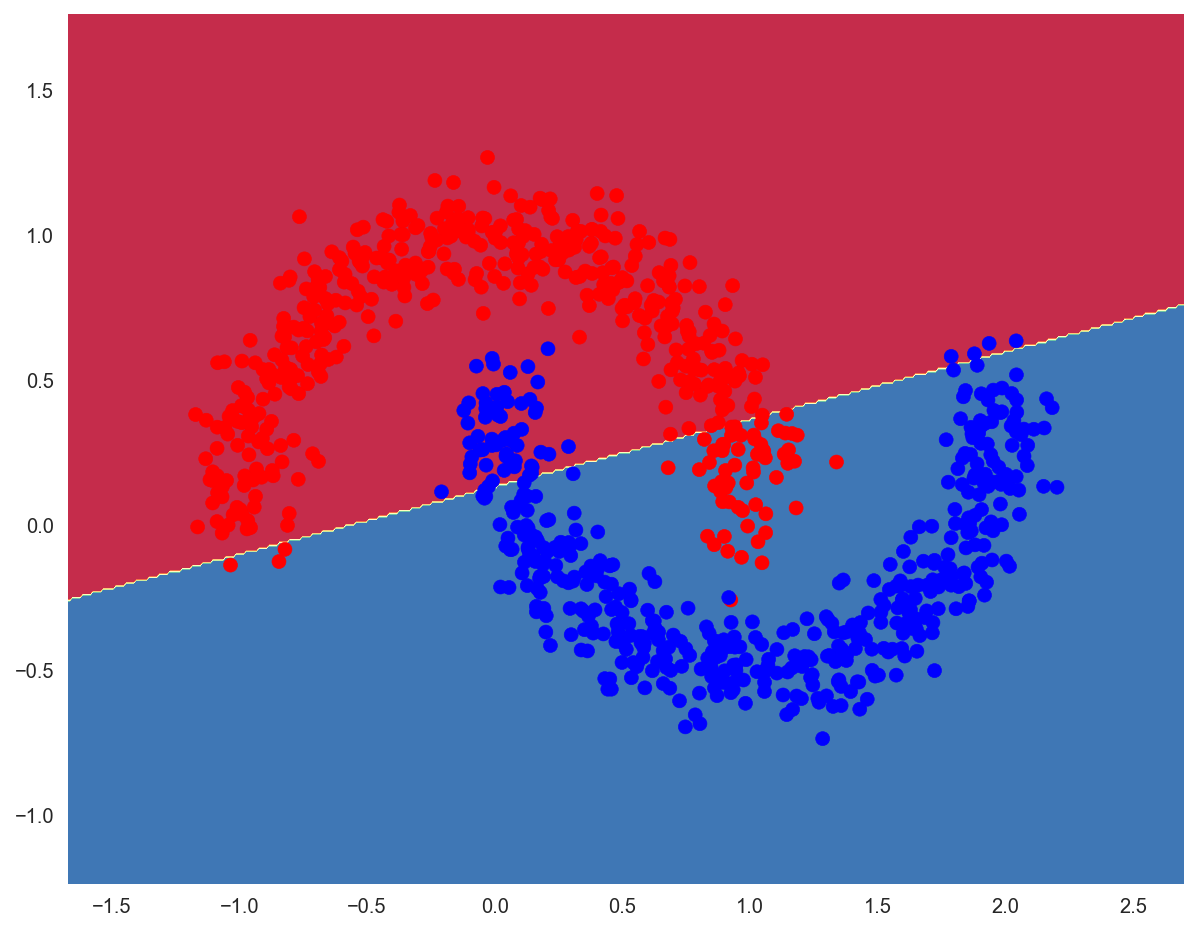

In [56]:
# Try the logistic regression algorithm on the data
model.fit(x_train, y_train)

accuracy = model.score(x_train, y_train)
print('Accuracy: ' + str(accuracy * 100) + '%')

plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

In [57]:
# Create a (2, 3, 1) neural network. Its hidden layer contains 3 neurons
model = Sequential()
model.add(Dense(3, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='sigmoid'))

# Describe the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


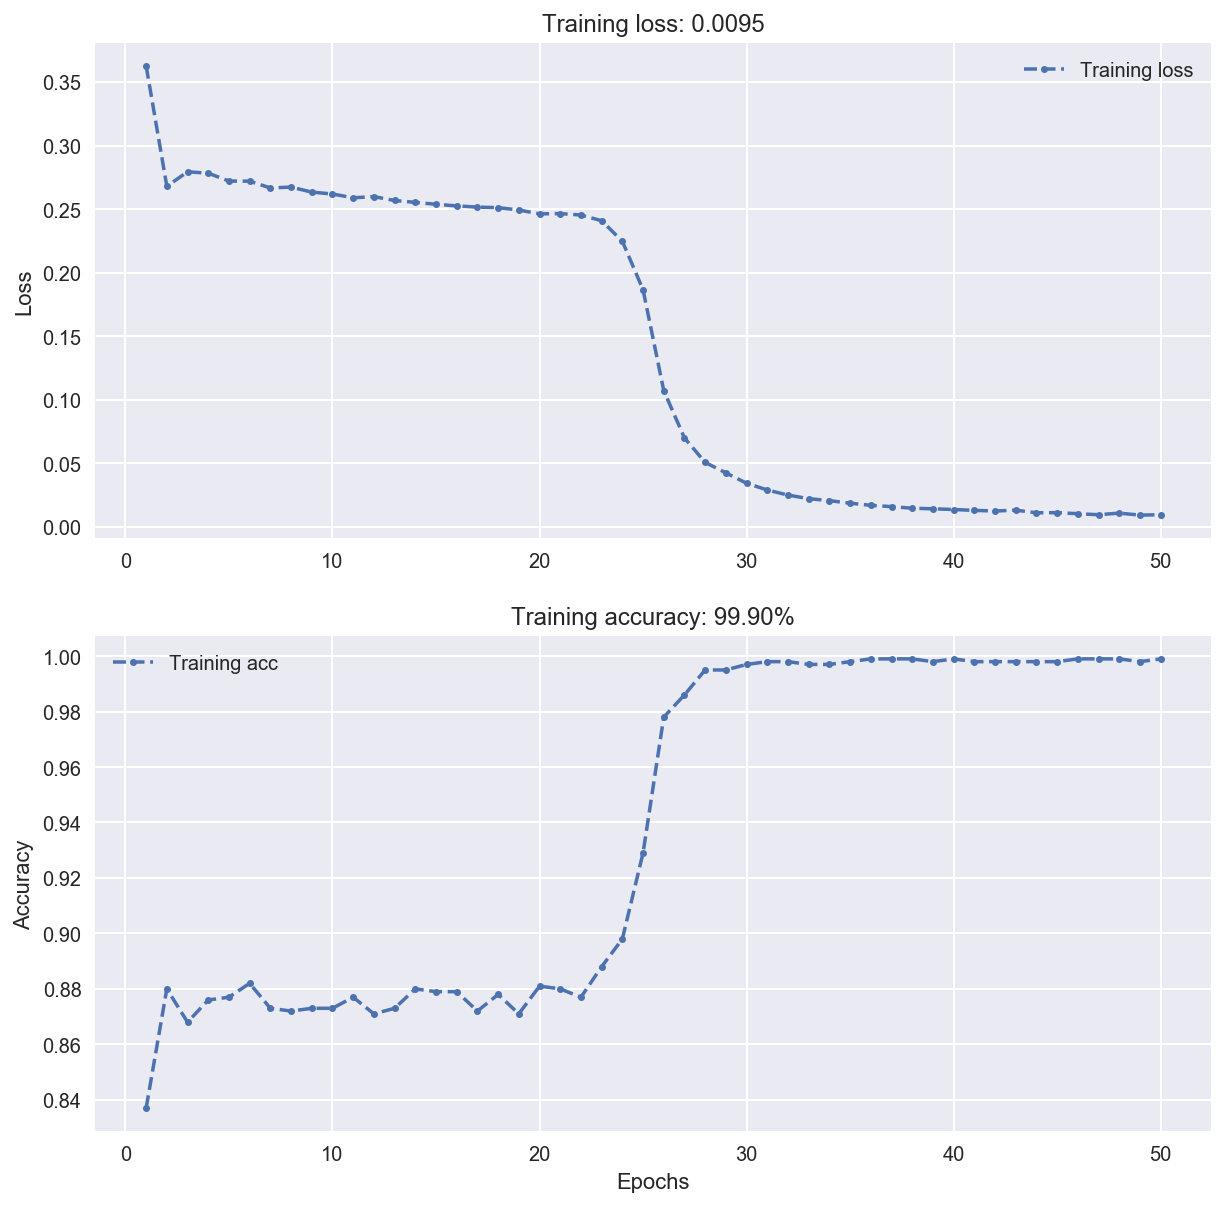

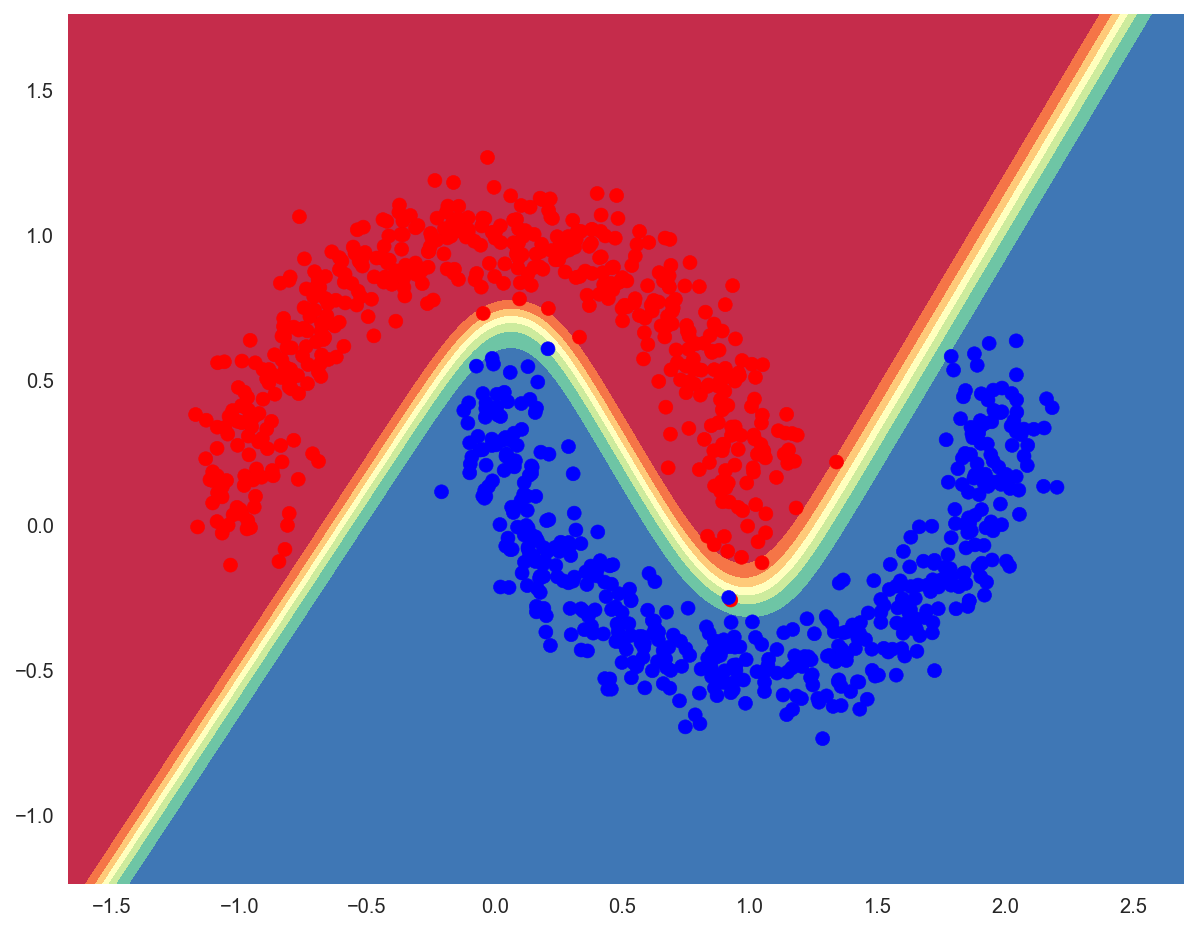

In [58]:
# Compile the model
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])

# Train the model on the data
history = model.fit(x_train, y_train, verbose=0, epochs=50)

# Show training results
plot_loss_acc(history)
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

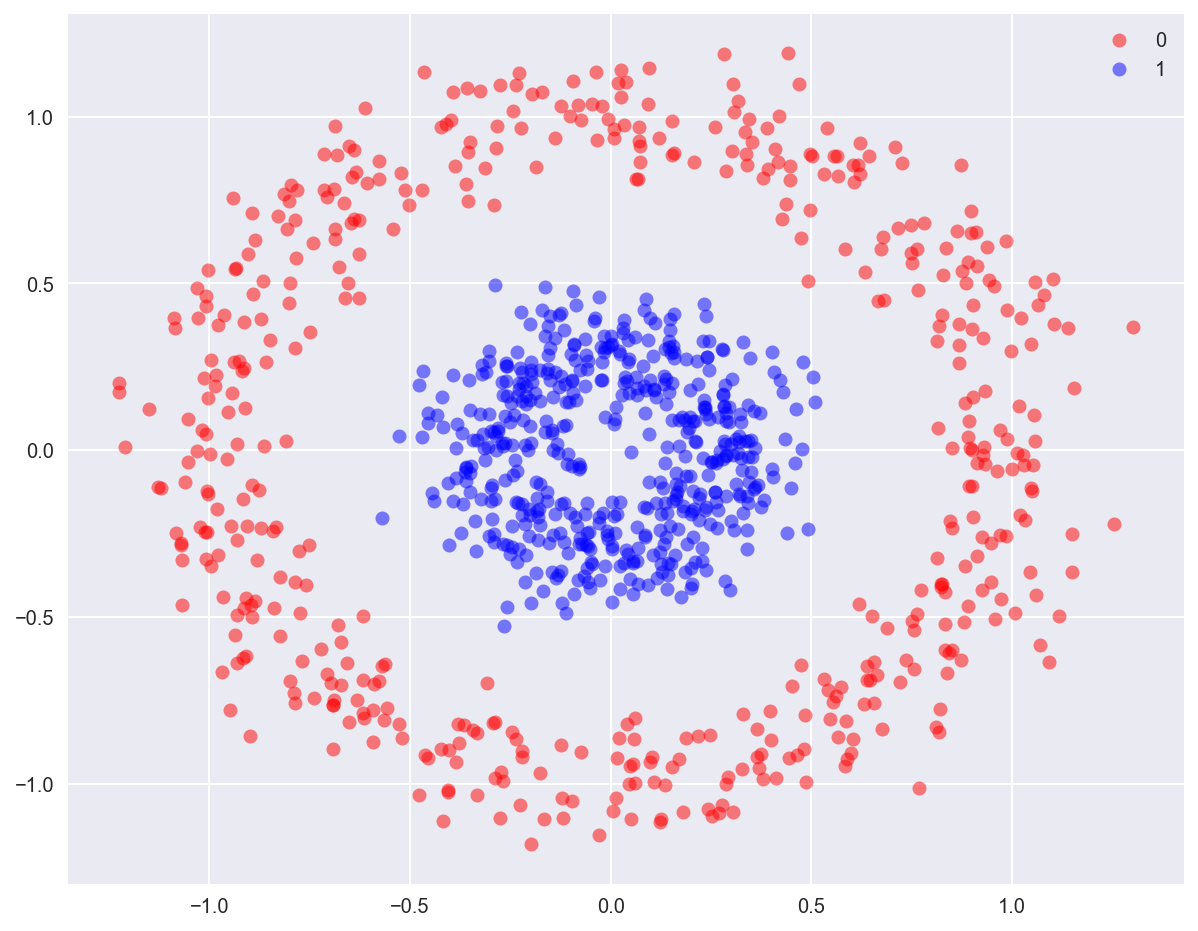

In [59]:
# Generate circle-shaped data
x_train, y_train = make_circles(n_samples=1000, noise=0.10, factor=0.3, random_state=0)
plot_data(x_train, y_train)

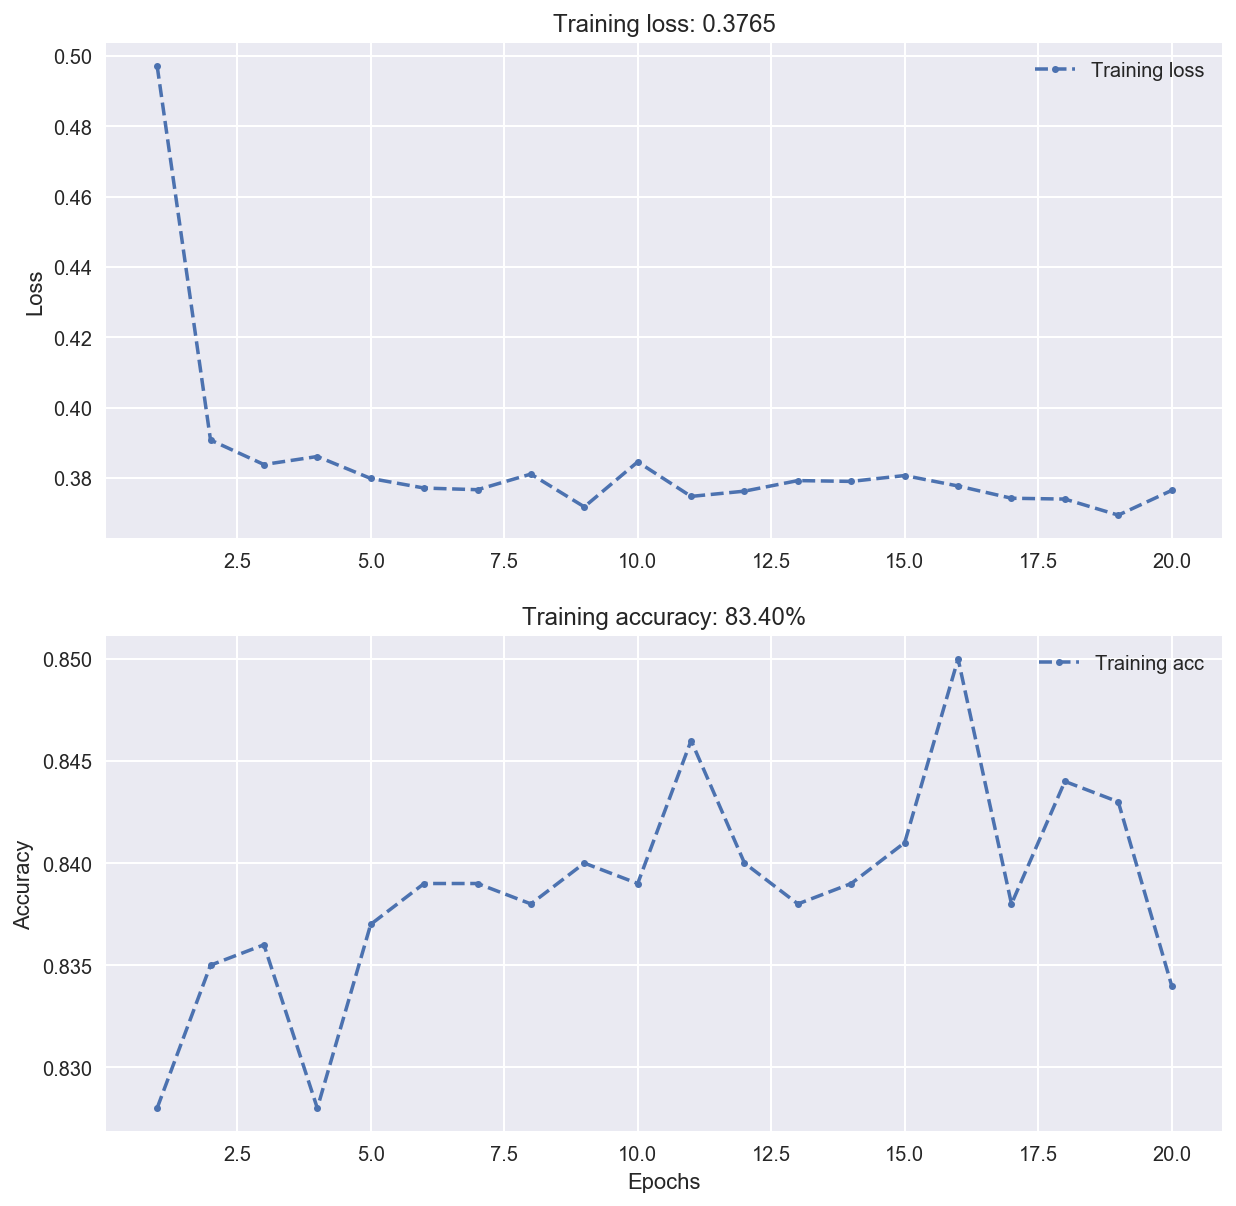

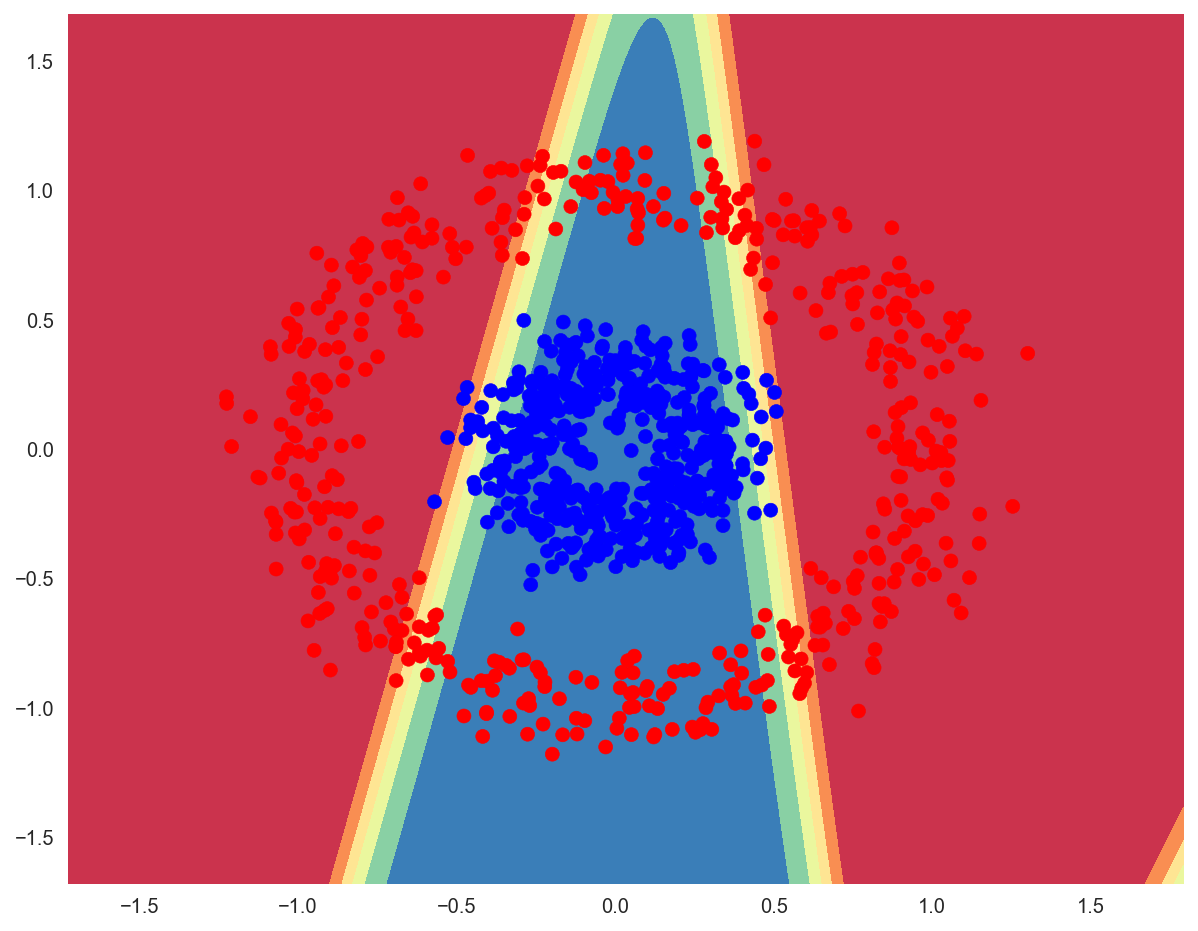

In [60]:
# Train the previous model on the data
history = model.fit(x_train, y_train, verbose=0, epochs=20)

# Show training results
plot_loss_acc(history)
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

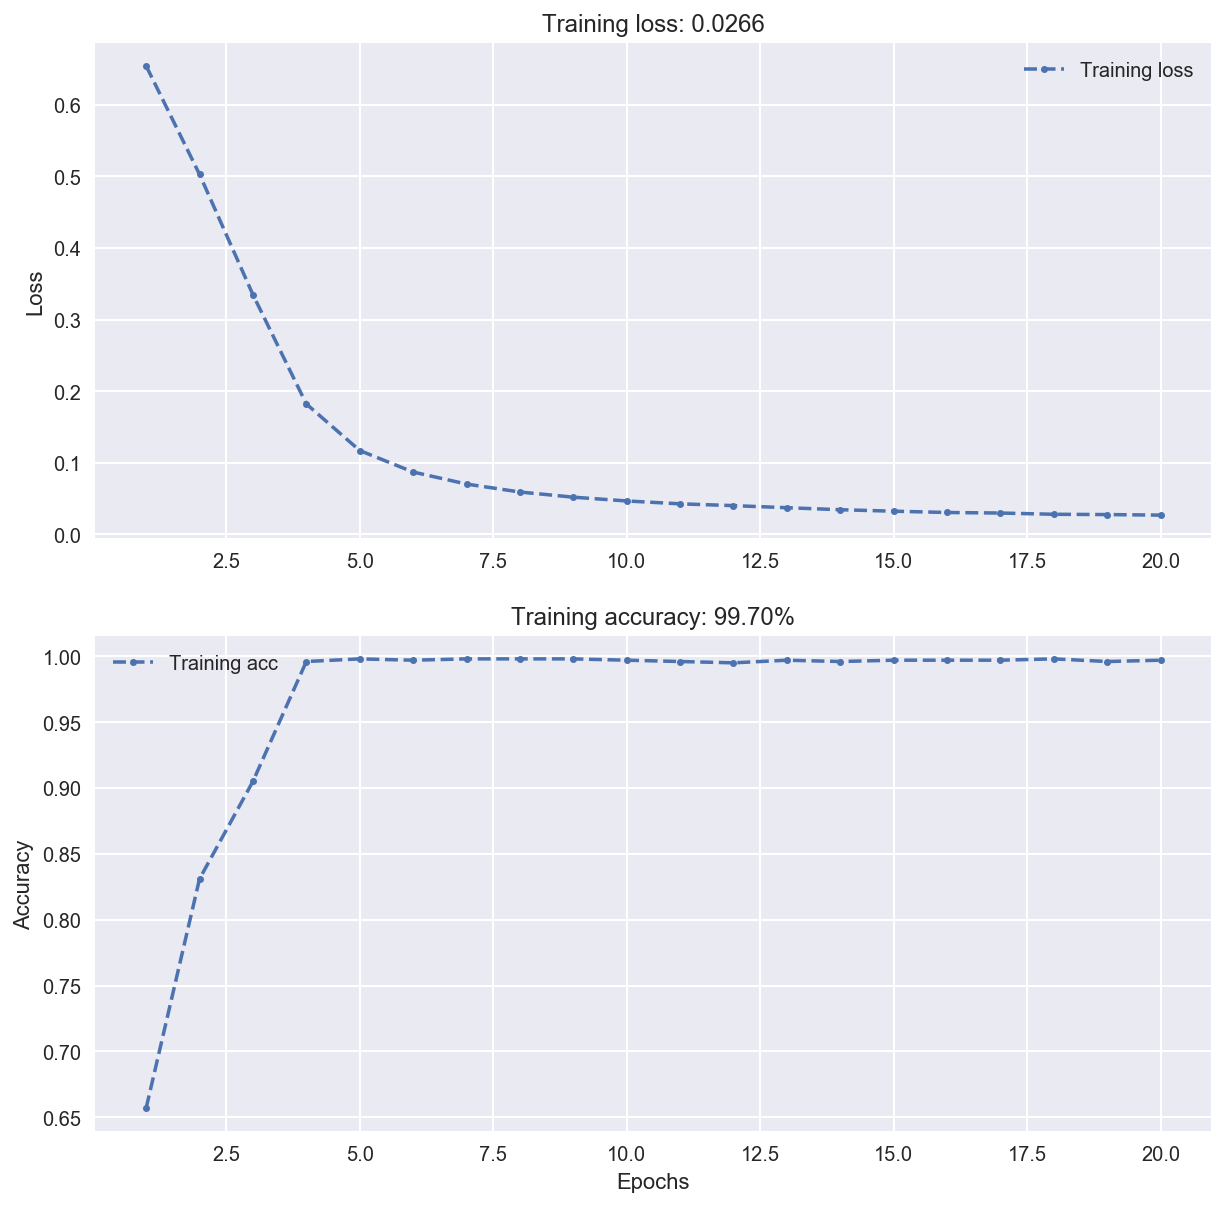

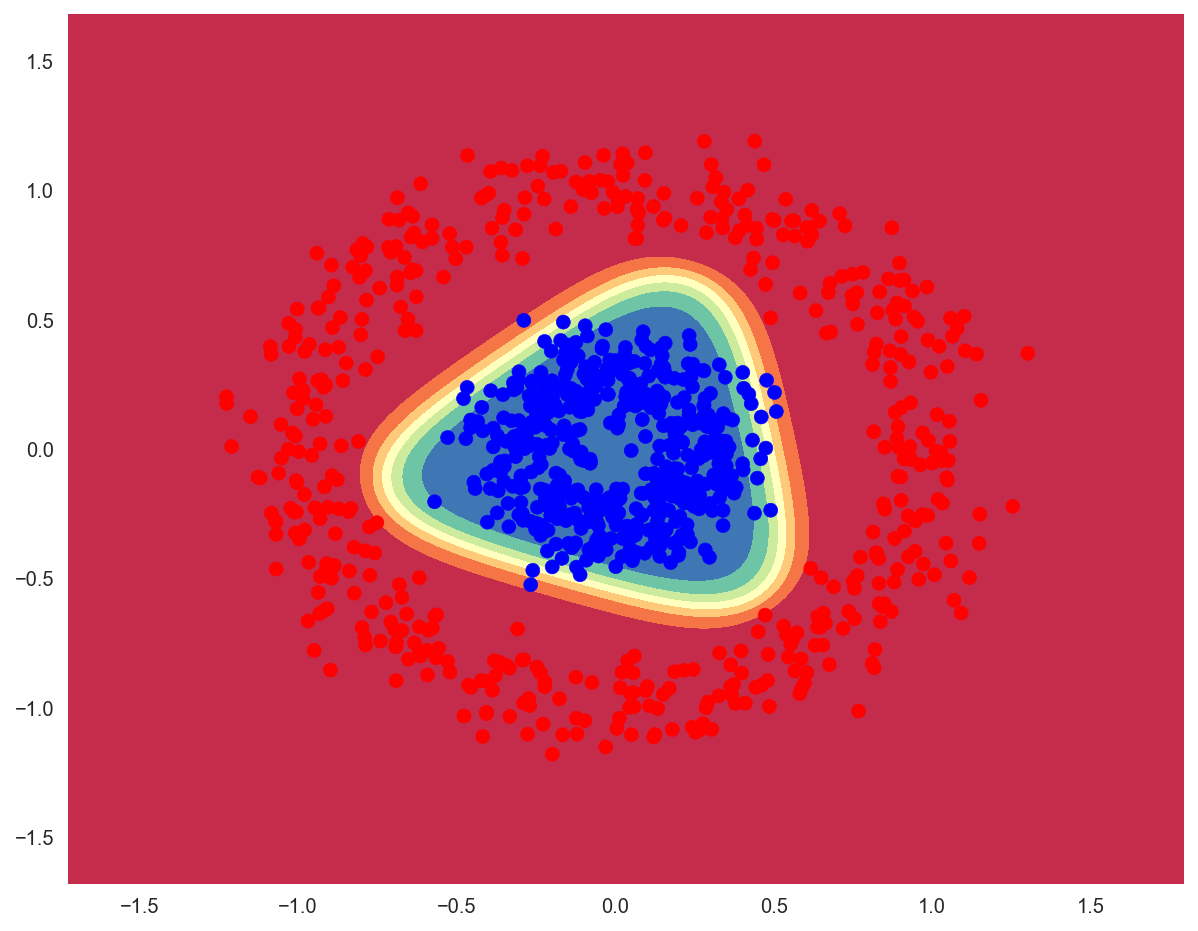

In [61]:
# Add a neuron on the hidden layer for better results
model = Sequential()
model.add(Dense(4, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])
# Train the model on the data
history = model.fit(x_train, y_train, verbose=0, epochs=20)

# Show training results
plot_loss_acc(history)
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

Input shape: (1500, 2). Original targets shape: (1500,)
Targets: [0. 0. 0. ... 2. 2. 2.]


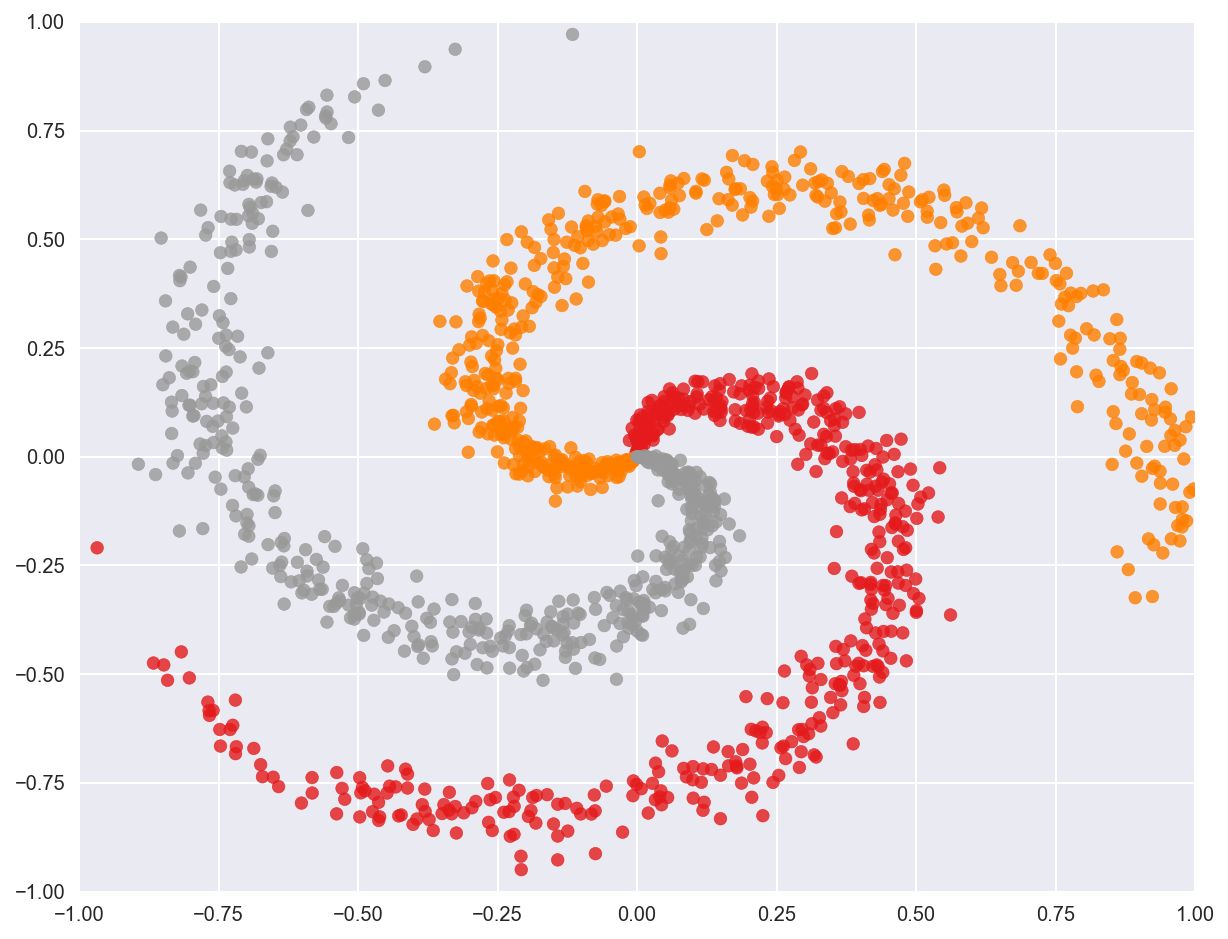

In [62]:
# Generate and plot spiral-shaped data with 3 classes
x_train, targets = make_multiclass(K=3)

print('Input shape: ' + str(x_train.shape) +
      '. Original targets shape: ' + str(targets.shape))
print('Targets: ' + str(targets))

In [63]:
# to_categorical() converts a vector of values into a binary matrix
# This is called one-hot encoding
y_train = to_categorical(targets)

print('Encoded targets shape: ' + str(y_train.shape))

# Show a sample of encoded input
df = pd.DataFrame(y_train)
df.sample(n=10)

Encoded targets shape: (1500, 3)


,0,1,2
1338,0.0,0.0,1.0
526,0.0,1.0,0.0
1192,0.0,0.0,1.0
809,0.0,1.0,0.0
1051,0.0,0.0,1.0
926,0.0,1.0,0.0
56,1.0,0.0,0.0
487,1.0,0.0,0.0
468,1.0,0.0,0.0
765,0.0,1.0,0.0


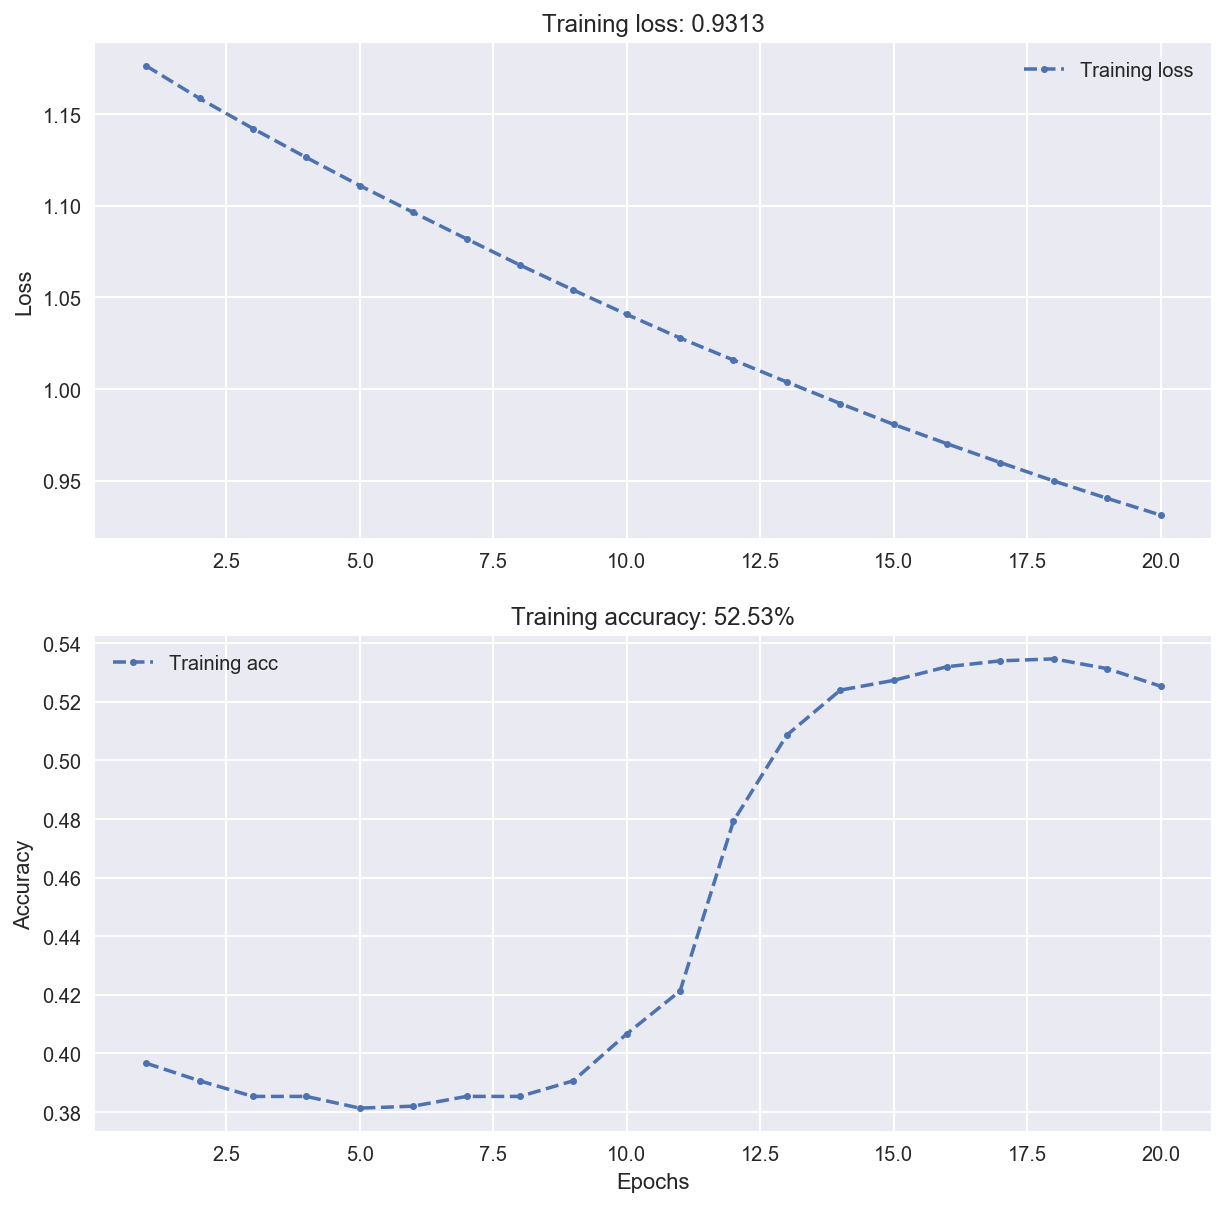

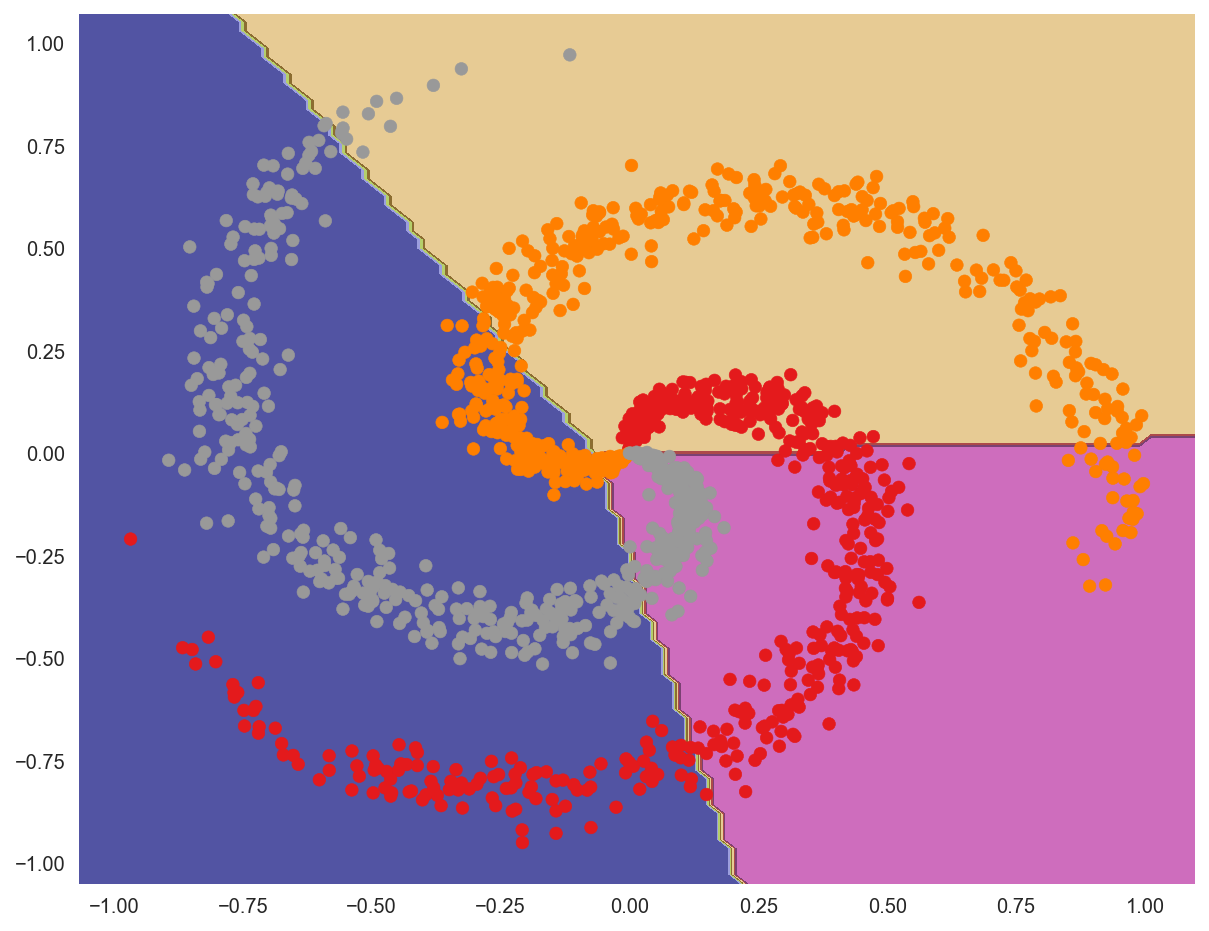

In [64]:
# Create a (2, 3, 3) model with a softmax activation function on the output layer
model = Sequential()
model.add(Dense(3, activation='softmax', input_shape=(2,)))

model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, verbose=0, epochs=20)

plot_loss_acc(history)
plot_multiclass_decision_boundary(model, x_train, targets)

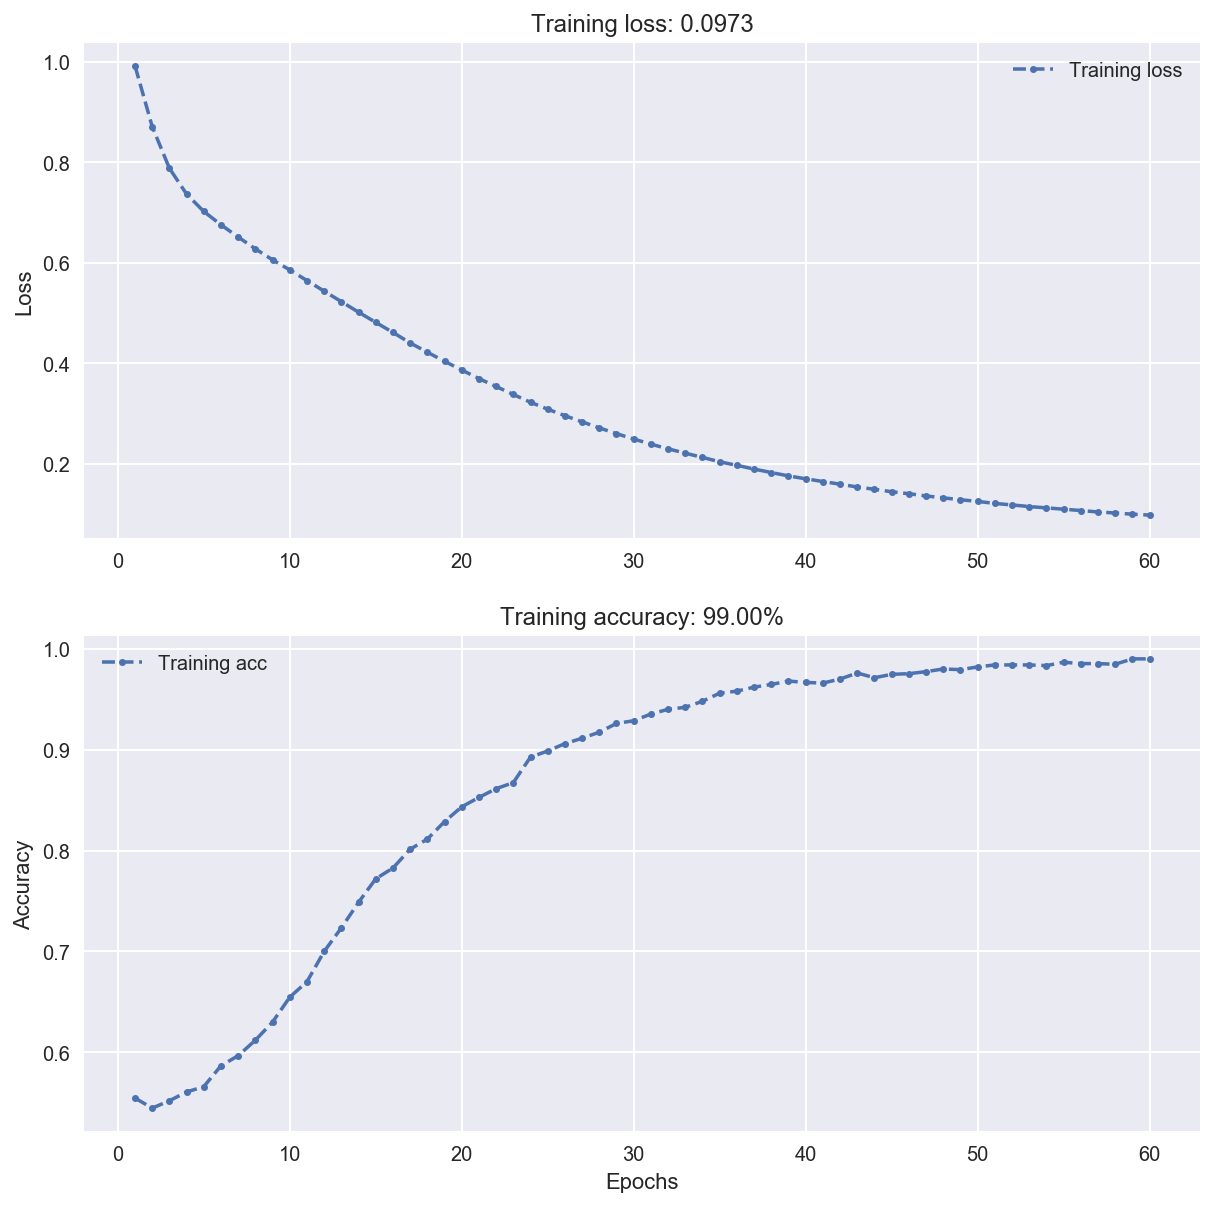

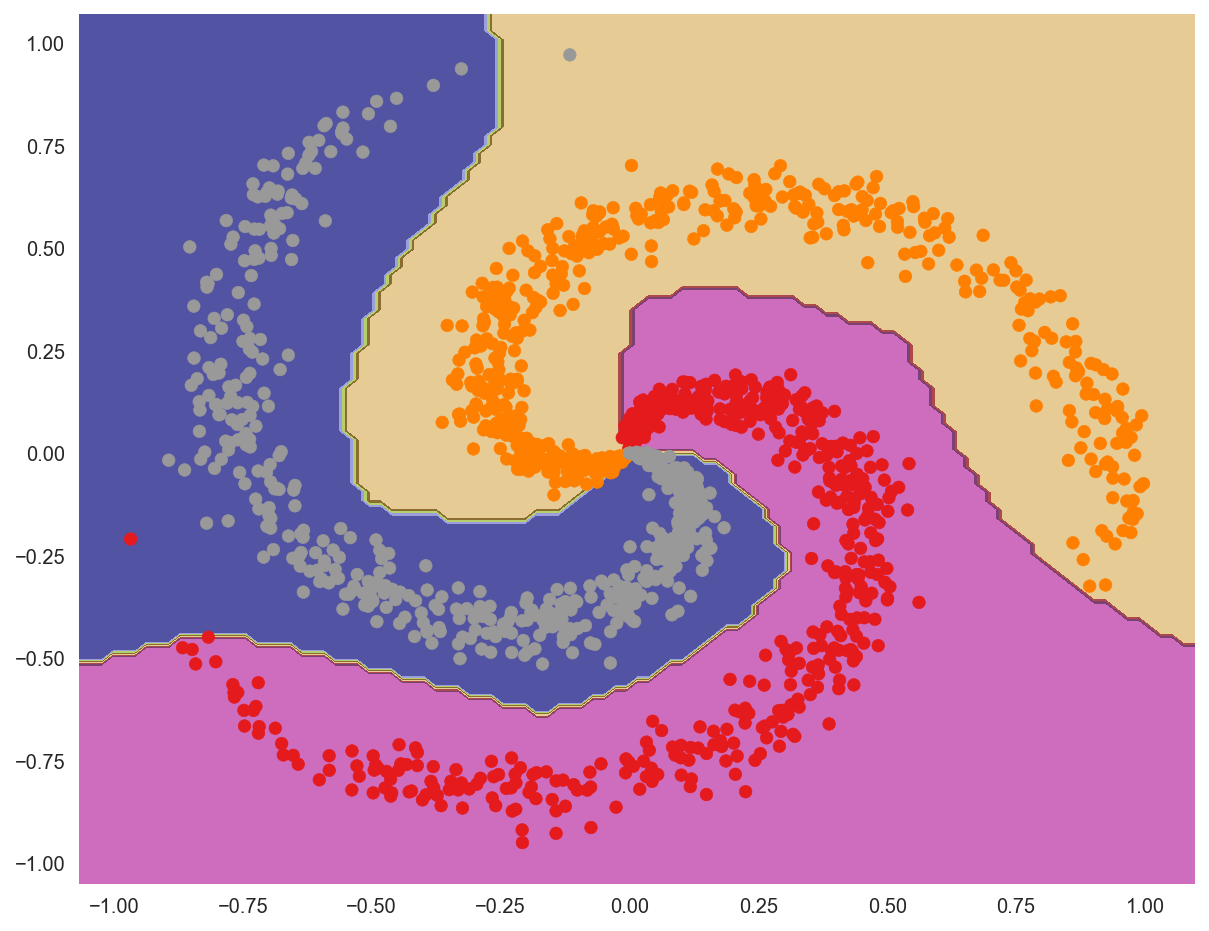

In [65]:
# Change model architecture to a (2, 100, 3) network
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(2,)))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, verbose=0, epochs=60)
plot_loss_acc(history)
plot_multiclass_decision_boundary(model, x_train, targets)

## MNIST Digits

In [66]:
# Load the Keras MNIST digits dataset
(train_images, train_targets), (test_images, test_targets) = mnist.load_data()

print('Training images shape: ' + str(train_images.shape))
print('Training targets shape: ' + str(train_targets.shape))
print('Targets: ' + str(train_targets))

Training images shape: (60000, 28, 28)
Training targets shape: (60000,)
Targets: [5 0 4 ... 5 6 8]


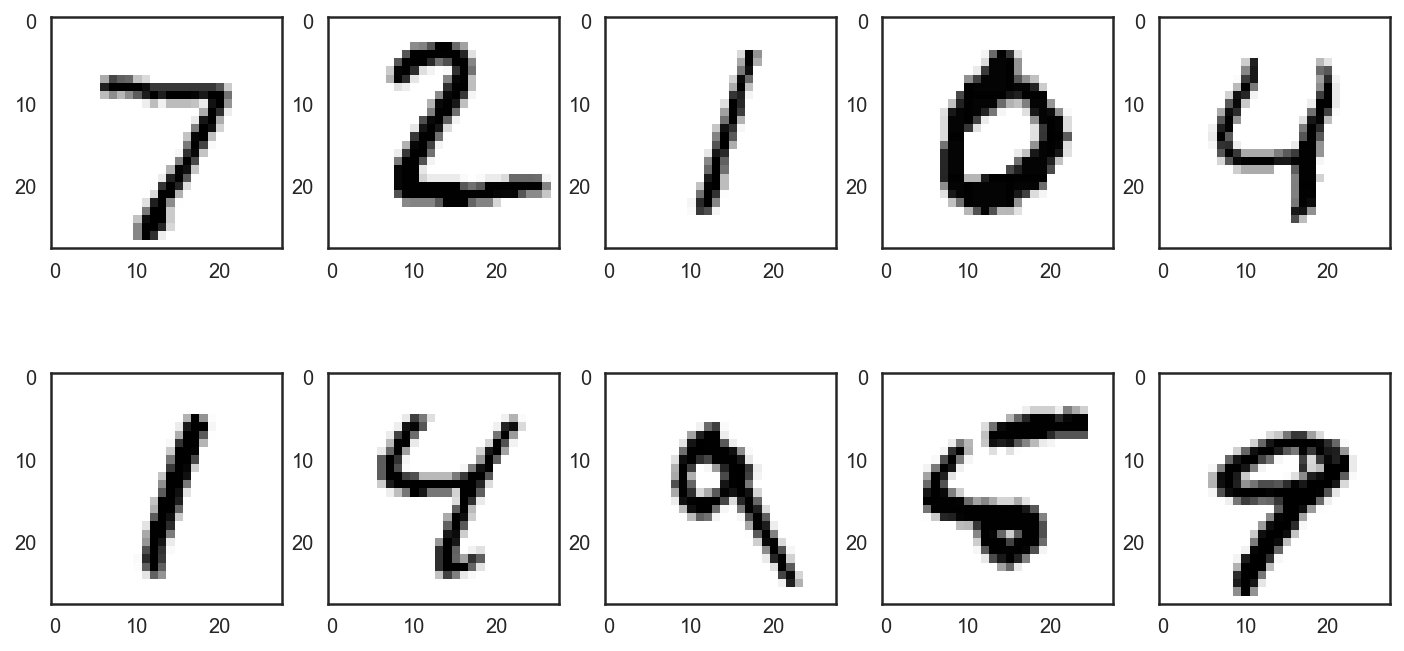

In [67]:
# Plot the first 10 digits

# Temporary hide Seaborn grid lines
with sns.axes_style('white'):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        digit = test_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(digit, cmap=plt.cm.binary)

In [68]:
# Reshape images data into a (number of samples, 28x28) matrix
x_train = train_images.reshape((60000, 28 * 28))
x_test = test_images.reshape((10000, 28 * 28))

# Change pixel values from (0, 255) to (0, 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encoding of expected results
y_train = to_categorical(train_targets)
y_test = to_categorical(test_targets)

print('Encoded targets shape: ' + str(y_train.shape))

# Show a sample of encoded input
df = pd.DataFrame(y_train)
df.sample(n=10)

Encoded targets shape: (60000, 10)


,0,1,2,3,4,5,6,7,8,9
53811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37880,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34175,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
41021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36912,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Create a (784, 15, 10) model
model = Sequential()
model.add(Dense(15, activation='relu', input_shape=(28 * 28,)))
model.add(Dense(10, activation='softmax'))

# Describe the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 15)                11775     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.5773 - acc: 0.8433
Epoch 2/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.2946 - acc: 0.9163
Epoch 3/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.2593 - acc: 0.9258
Epoch 4/10
60000/60000 [==============================] - 1s 25us/step - loss: 0.2390 - acc: 0.9313
Epoch 5/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.2243 - acc: 0.9359
Epoch 6/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.2131 - acc: 0.9396
Epoch 7/10
60000/60000 [==============================] - 1s 25us/step - loss: 0.2050 - acc: 0.9416
Epoch 8/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.1971 - acc: 0.9443
Epoch 9/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.1913 - acc: 0.9455
Epoch 10/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.1865 - acc: 0.9461

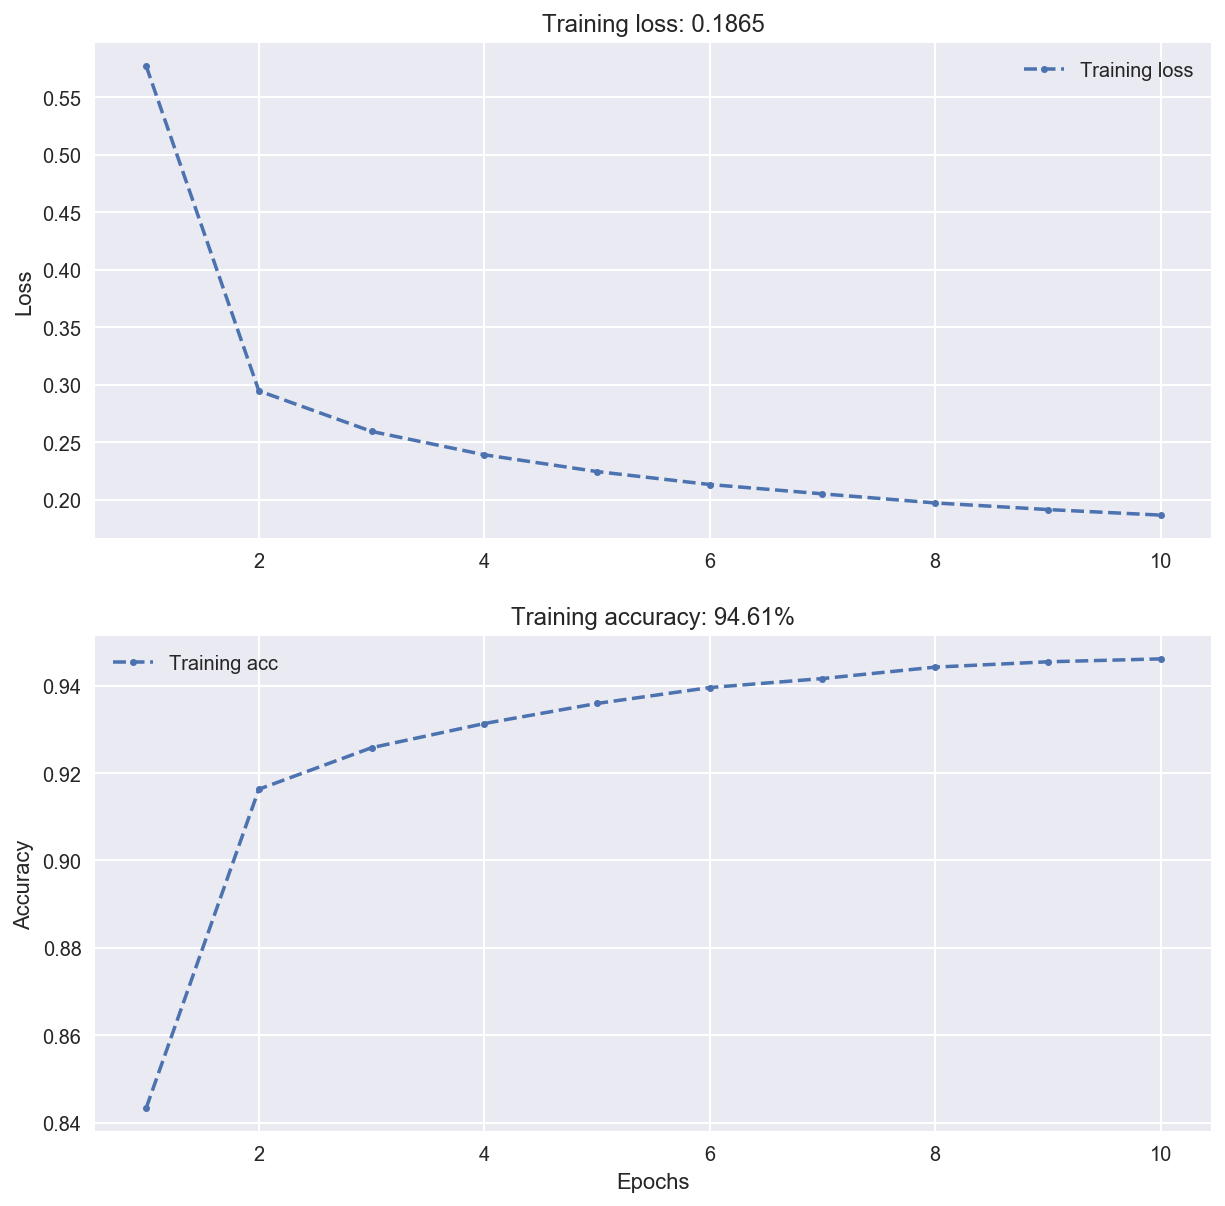

In [70]:
# Train the model and show results
model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128)
plot_loss_acc(history)

In [73]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: ' + str(test_acc * 100) + '%')

Test accuracy: 93.81%


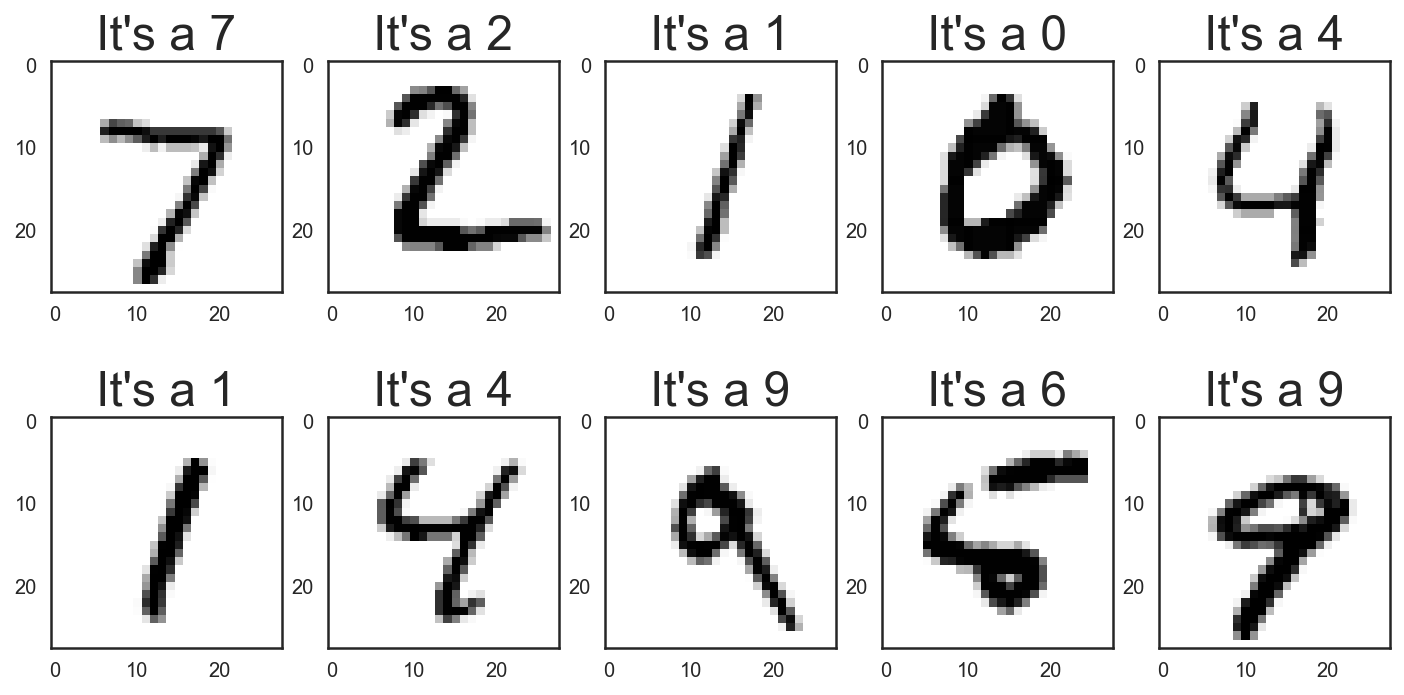

In [72]:
# Plot the first 10 digits with associated predictions

# Temporary hide Seaborn grid lines
with sns.axes_style('white'):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        digit = test_images[i]
        prediction = np.argmax(model.predict(
            digit.reshape((1, 28 * 28))))
        fig = plt.subplot(2, 5, i + 1)
        plt.title('It\'s a {:d}'.format(prediction), fontsize=24)
        plt.imshow(digit, cmap=plt.cm.binary)